### Overview

In this notebook, we focus on cleaning the initial dataset and handling NaN values, unifying columns and job titles, extracting company names, assigning emotional flags, and analyzing the differences between the initial dataset and the selected sample.

Initial dataset
- https://www.kaggle.com/datasets/davidgauthier/glassdoor-job-reviews-2

Timeframe: 2014 to 2023

### Columns: 

- rating: overall rating given by the employee (e.g., 5.0 out of 5)
- status: indicates whether the reviewer is a current or former employee.
- pros: lists the positive aspects of the company or job 
- cons: lists the negative aspects faced in the company or job
- recommend: indicates whether the employee would recommend the company to others
- ceo_approval: reflects the employee’s opinion on the CEO’s leadership
- career_opportunities: a rating indicating opportunities for professional growth and advancement
- compensation_and_benefits: a rating reflecting satisfaction with salary, bonuses, and other benefits
- senior_management: a rating evaluating the performance and effectiveness of senior leadership or management
- work/life_balance: a rating that assesses how well the company supports balance between work and personal life
- culture_and_values: a rating reflecting the company’s culture, values, and overall work environment
- diversity_and_inclusion: a rating indicating the company’s efforts for an inclusive and diverse workplace
- job: job title of the reviewer providing the feedback
- year: when the review was submitted
- firm_name: name of the company being reviewed

Emotional flags (Additional well-being indicators)

- Stress Flag: Indicators of job-related stress
- Burnout Flag: Signs of employee burnout
- Anxiety Flag: Mentions of anxiety in reviews
- Supportive Environment Flag: Indicators of supportive workplaces
- Toxic Flag: Signs of toxic work environments
- Depression Flag: Mentions of depressive symptoms

### Import libraries with neccessary functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import spacy
from collections import Counter
from textblob import TextBlob
from tqdm.notebook import tqdm


### Load the initial dataset from Kaggle

In [2]:
reviews = pd.read_csv("../data/raw/all_reviews.csv", low_memory=False)

### Get the fundamental overview

In [ ]:
reviews.shape

(9901889, 19)

In [ ]:
reviews.head()

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,firm_link,date,job,index
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,NaN,v,o,v,3,3,3,3,3.0,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design,NaN
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",NaN,v,o,o,4,4,4,4,4.0,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee,NaN
2,4.0,"Supervising the manufacturing the processes, e...","Current Employee, more than 1 year",This company is a best opportunity for me to l...,"Monthly Target work,Maintain production schedu...",NaN,v,o,v,2,3,2,2,2.0,2.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Aug 12, 2021",Production Engineer,NaN
3,1.0,terrible,"Current Employee, more than 1 year",I wish there were some to list,too many to list here,NaN,x,x,x,1.0,3.0,1.0,3.0,1.0,NaN,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Sep 24, 2020",Senior Account Executive,NaN
4,4.0,"It could be so good, but it isn’t","Current Employee, more than 3 years",Fast Paced. Endless challenges. Inclusive envi...,The biggest perk of the job provides no value ...,NaN,o,o,o,3.0,3.0,3.0,1.0,4.0,5.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Mar 25, 2023",Assistant Manager,NaN


### Cleaning functions

In [ ]:
# Function to clean numerical rating columns
def clean_rating_columns(df, columns):
    """
    Clean numerical rating columns by converting them to float and removing invalid entries.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=[col])
        df[col] = df[col].astype(float)
    return df

# Function to handle missing values
def handle_missing_values(df, columns_to_fill, fill_value=0.0):
    """
    Fill missing values for specified columns with a given value.
    """
    for col in columns_to_fill:
        df[col] = df[col].fillna(fill_value).astype(float)
    return df

# Function to extract year from date
def extract_year(df, date_column, year_column):
    """
    Extract the year from a date column and create a new year column.
    """
    df[year_column] = df[date_column].str.split().str[2].astype(int)
    df.drop(columns = "date", inplace = True)
    return df[df[year_column] > 2014]

# Function to extract firm names from the firm_link
def extract_firm_names(df, firm_link_column, firm_name_column):
    """
    Extract firm names from firm_link and filter firms with frequent mentions.
    """
    def extract_name(firm_link):
        match = re.search(r'(?<=/)([A-Za-z0-9\-]+)(?=-Reviews)', firm_link)
        return match.group(1) if match else None

    df[firm_name_column] = df[firm_link_column].apply(extract_name)
    df.drop(columns = "firm_link", inplace=True)
    firm_counts = df[firm_name_column].value_counts()
    valid_firms = firm_counts[firm_counts >= 100].index
    
    return df[df[firm_name_column].isin(valid_firms)]

# Function to unify employment statuses
def unify_employment_statuses(df, status_column):
    """
    Standardize employment statuses.
    """
    def unify_status(status):
        if "Current" in status:
            if "Contractor" in status:
                return "Current Contractor"
            elif "Freelancer" in status:
                return "Current Freelancer"
            elif "Intern" in status:
                return "Current Intern"
            elif "Self-employed" in status:
                return "Current Self-employed"
            else:
                return "Current Employee"
        elif "Former" in status:
            if "Contractor" in status:
                return "Former Contractor"
            elif "Freelancer" in status:
                return "Former Freelancer"
            elif "Intern" in status:
                return "Former Intern"
            elif "PhD" in status:
                return "Former PhD"
            elif "Self-employed" in status:
                return "Former Self-employed"
            else:
                return "Former Employee"
        else:
            return "Other"

    df[status_column] = df[status_column].apply(unify_status)
    return df

# Main cleaning function
def clean_dataset(file_path, rating_columns, missing_columns, firm_link_column, status_column, date_column, year_column, job_column):
    """
    Clean the dataset by applying all cleaning functions step by step.
    """
    # Read the data
    df = pd.read_csv(file_path, low_memory=False)
    
    # Clean rating columns
    df = clean_rating_columns(df, rating_columns)
    
    # Drop unnecessary columns
    df.drop(columns=["title", "advice", "index", "Business Outlook"], inplace=True)
    
    # Drop rows with significant missing values
    df.dropna(subset=['pros', 'cons', 'Culture & Values'], inplace=True)

    #Unify names of the columns and reset index
    df['pros'] = df['pros'].str.lower().str.replace(r'\n', ' ', regex=True)
    df['cons'] = df['cons'].str.lower().str.replace(r'\n', ' ', regex=True)
    
    
    # Extract year and filter rows
    df = extract_year(df, date_column, year_column)
    
    # Handle missing values in specific columns
    df = handle_missing_values(df, missing_columns, fill_value=0.0)
    
    # Extract and filter firm names
    df = extract_firm_names(df, firm_link_column, 'firm_name')

    # Unify employment statuses
    df = unify_employment_statuses(df, status_column)
    
    return df

# Usage
file_path = "../data/raw/all_reviews.csv"
rating_columns = ['Work/Life Balance', 'Compensation and Benefits', 'Senior Management', 'Career Opportunities']
missing_columns = ['Diversity & Inclusion']
firm_link_column = 'firm_link'
status_column = 'status'
date_column = 'date'
year_column = 'year'
job_column = 'job'

cleaned_reviews = clean_dataset(
    file_path=file_path,
    rating_columns=rating_columns,
    missing_columns=missing_columns,
    firm_link_column=firm_link_column,
    status_column=status_column,
    date_column=date_column,
    year_column=year_column,
    job_column=job_column
)

# Check missing values in the cleaned dataset
print(cleaned_reviews.isna().sum())


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/2601259814.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/2601259814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


rating                       0
status                       0
pros                         0
cons                         0
Recommend                    0
CEO Approval                 0
Career Opportunities         0
Compensation and Benefits    0
Senior Management            0
Work/Life Balance            0
Culture & Values             0
Diversity & Inclusion        0
job                          0
year                         0
firm_name                    0
dtype: int64


### Unify column names

In [ ]:
#lowercase column names and replace space by "_"
cleaned_reviews.columns = cleaned_reviews.columns.str.lower().str.replace(" ", "_", regex=True).str.replace("&", "and", regex=True)
cleaned_reviews.reset_index(drop=True, inplace=True)
print(cleaned_reviews.shape)
display(cleaned_reviews.head())

(6016214, 15)


,rating,status,pros,cons,recommend,ceo_approval,career_opportunities,compensation_and_benefits,senior_management,work/life_balance,culture_and_values,diversity_and_inclusion,job,year,firm_name
0,5.0,Current Employee,great life canada i liked,my dream canada working and enjoy the life,v,v,4.0,3.0,4.0,5.0,3.0,4.0,Delivery Post Person With Driving,2023,Canada-Life
1,5.0,Current Employee,best place to work always,system is a bit old,v,v,4.0,4.0,4.0,4.0,4.0,4.0,Manager,2023,Canada-Life
2,1.0,Former Employee,the pro is you get paid... i guess. i worked o...,"just felt like another cog in the machine, wor...",v,v,1.0,1.0,1.0,1.0,1.0,1.0,Customer Service Specialist,2022,Canada-Life
3,1.0,Former Employee,my peers were good to work with. everyone will...,"leadership is not helpful at all, they walk ar...",x,x,1.0,3.0,1.0,2.0,2.0,2.0,Anonymous Employee,2022,Canada-Life
4,4.0,Current Employee,great team with strong focus on personal devel...,company size often results in slow executive d...,v,v,4.0,3.0,4.0,4.0,5.0,5.0,Senior Workplace Strategist,2022,Canada-Life


### Cleaning job titles

In [ ]:
def clean_job_titles(df, job_column):
    """
    Clean and standardize job titles in a DataFrame.

    """
    # Replace empty strings or NaN values with "Anonymous Employee"
    df[job_column].replace(' ', 'Anonymous Employee', inplace=True)
    df[job_column].fillna('Anonymous Employee', inplace=True)
    
    # Strip leading/trailing spaces
    df[job_column] = df[job_column].str.strip()
    
    # Count occurrences of each job title
    job_counts = df[job_column].value_counts()
    
    # Filter out jobs mentioned less than 100 times
    valid_jobs = job_counts[job_counts >= 100].index
    df = df[df[job_column].isin(valid_jobs)]
    
    # Replace specific job titles
    job_replacements = {
        'Salees Associate': 'Sales Associate', 'Sales Executive': 'Sales Associate',
        'IT Strategy Consultant': 'IT Consultant',
        'Sales Associate/Cashier': 'Cashier', 'Front End Cashier': 'Cashier',
        'Senior Software Engineer': 'Software Engineer', 
        'Senior Systems Engineer': 'Software Engineer', 
        'Senior Software Developer': 'Software Engineer', 
        'Associate Software Engineer': 'Software Engineer',
        'Sales': 'Sales Associate', 
        'Salees Associate ': 'Sales Associate', 
        'Retail Sales Associate': 'Sales Associate',
        'Sales Assistant': 'Sales Associate', 
        'Sales Representative': 'Sales Associate', 'Inside Sales Representative': 'Sales Associate',
        'Systems Engineer': 'Software Engineer', 'Senior Engineer':'Software Engineer',
        'Senior Associate': 'Associate', 
        'Senior Analyst ': 'Analyst',
        'Business Analyst': 'Analyst', 'Senior Business Analyst ': 'Analyst','Senior Business Analyst': 'Analyst', 'Financial Analyst': 'Analyst',
        'IT Analyst': 'Analyst', 'Senior Analyst': 'Analyst', 'Programmer Analyst': 'Analyst',
        'Server': 'Waiter/Waitress', 'Waiter': 'Waiter/Waitress', 'Waitress': 'Waiter/Waitress',
        'Warehouse Worker': 'Warehouse Associate',
        'Human Resources': 'HR', 
        'Recruiter': 'HR',
        'Customer Service Representative': 'Customer Service', 
        'Customer Service Representative (CSR)': 'Customer Service', 'Customer Service Specialist': 'Customer Service',
        'Customer Assistant': 'Customer Service', 
        'Customer Service Associate': 'Customer Service',
        'Executive Assistant': 'Administrative Assistant', 
        'Associate Director': 'Director',
        'Shift Supervisor': 'Supervisor',
        'Graduate Research Assistant': 'Researcher','Research Assistant': 'Researcher',
    }
    df[job_column] = df[job_column].replace(job_replacements)
    
    # Apply broader job title standardizations
    def standardize_jobs(job):
        if 'Teacher' in job:
            return 'Teacher'
        elif 'Manager' in job:
            return 'Manager'
        elif 'Consultant' in job:
            return 'Consultant'
        elif 'Teller' in job:  
            return 'Bank Teller'
        elif 'Intern' in job:
            return 'Intern'
        elif 'Pharmacy' in job:
            return 'Pharmacy'
        elif 'Team Member' in job or 'Crew Member' in job:
            return 'Team Member'
        return job
    
    df[job_column] = df[job_column].apply(standardize_jobs)
    
    return df

In [ ]:
cleaned_reviews = clean_job_titles(cleaned_reviews, 'job') #apply the job cleaning function

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/594635548.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].replace(job_replacements)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/594635548.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].apply(standardize_jobs)


In [ ]:
cleaned_reviews.reset_index(inplace=True)
cleaned_reviews.rename(columns={'index': 'review_id'}, inplace=True)
cleaned_reviews.head()

,review_id,rating,status,pros,cons,recommend,ceo_approval,career_opportunities,compensation_and_benefits,senior_management,work/life_balance,culture_and_values,diversity_and_inclusion,job,year,firm_name
0,1,5.0,Current Employee,best place to work always,system is a bit old,v,v,4.0,4.0,4.0,4.0,4.0,4.0,Manager,2023,Canada-Life
1,2,1.0,Former Employee,the pro is you get paid... i guess. i worked o...,"just felt like another cog in the machine, wor...",v,v,1.0,1.0,1.0,1.0,1.0,1.0,Customer Service,2022,Canada-Life
2,3,1.0,Former Employee,my peers were good to work with. everyone will...,"leadership is not helpful at all, they walk ar...",x,x,1.0,3.0,1.0,2.0,2.0,2.0,Anonymous Employee,2022,Canada-Life
3,5,4.0,Current Employee,good salary\r inclusive environment\r caring f...,i don't have any cons.,v,v,4.0,4.0,4.0,4.0,4.0,4.0,Analyst,2022,Canada-Life
4,6,1.0,Former Employee,co-workers and close to public tramsit,high caseload\r incompetent management \r unre...,x,x,1.0,1.0,1.0,1.0,1.0,1.0,Manager,2022,Canada-Life


### Well-bwing indicators correlation matrix

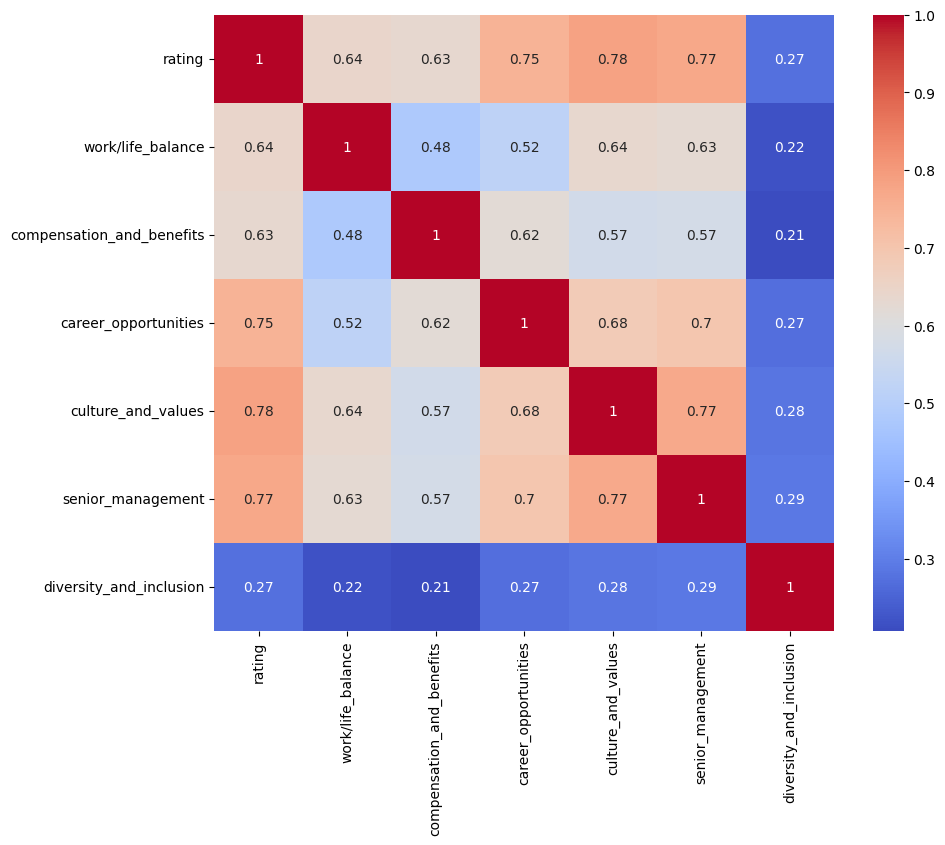

In [ ]:
# Select relevant numerical columns
numerical_cols = ['rating', 'work/life_balance', 'compensation_and_benefits', 'career_opportunities', 'culture_and_values', 'senior_management','diversity_and_inclusion']
corr_matrix = cleaned_reviews[numerical_cols].corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

- Work/Life Balance (0.64): Directly related to employee satisfaction and frequently highlighted as a key workplace factor.
- Culture & Values (0.78): Strongest correlation with rating, making it essential for analysis.
- Senior Management (0.77): Indicates a significant impact on employee perception.
- Career Opportunities (0.75): Highly correlated with rating, crucial for assessing growth potential and satisfaction.
- Diversity & Inclusion (0.66): While correlated, it’s slightly less impactful compared to the others. However, we might address how inclusivity initiatives affect workplace well-being and satisfaction

In [ ]:
cleaned_reviews["status"].value_counts()

status
Current Employee    2813365
Former Employee     2035375
Name: count, dtype: int64

In [ ]:
# Get the value counts for the 'job' column and sort them in descending order
job_counts = cleaned_reviews['job'].value_counts()

# Display the top 40 most frequent job titles
top_40_jobs = job_counts.head(40)
#print(top_40_jobs)

In [ ]:
backup_df = cleaned_reviews

### Preprocess pros and cons inputs for further analysis using spacy library and get the frequency counts

In [52]:
# reprocess the text using SpaCy
def preprocess_text_spacy(text):
    # parse the text using SpaCy
    doc = nlp(text.lower())
    
    # filter tokens: keep only alphabetic words, exclude stopwords and punctuation
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply the preprocessing function to 'pros' and 'cons' columns
top_pros = cleaned_reviews['pros'].head(50000).apply(preprocess_text_spacy)
top_cons = cleaned_reviews['cons'].head(50000).apply(preprocess_text_spacy)

# Function to get word frequencies
def get_word_frequencies(texts):
    all_tokens = []
    for text in texts:
        # Split by space as the text is already cleaned and lemmatized
        tokens = text.split()
        all_tokens.extend(tokens)
    
    # Count frequency of each token
    freq_counter = Counter(all_tokens)
    return freq_counter

# Get word frequencies for 'pros' and 'cons'
pros_word_freq = get_word_frequencies(top_pros)
cons_word_freq = get_word_frequencies(top_cons)

    

In [53]:
# Display the most common words
print("Most common words in 'pros':")
print(pros_word_freq.most_common(30))

print("\nMost common words in 'cons':")
print(cons_word_freq.most_common(30))

Most common words in 'pros':
[('work', 21844), ('good', 20254), ('great', 13588), ('people', 8087), ('company', 6377), ('benefit', 6362), ('environment', 5396), ('pay', 5282), ('opportunity', 4209), ('employee', 4075), ('life', 3852), ('lot', 3744), ('culture', 3699), ('team', 3689), ('balance', 3544), ('flexible', 3521), ('nice', 3499), ('job', 3444), ('learn', 3236), ('management', 3032), ('time', 2993), ('discount', 2979), ('place', 2965), ('hour', 2870), ('free', 2689), ('friendly', 2587), ('manager', 2059), ('easy', 2039), ('fun', 2037), ('food', 1920)]

Most common words in 'cons':
[('work', 16626), ('management', 9145), ('pay', 7709), ('hour', 7642), ('company', 6417), ('time', 6087), ('employee', 5716), ('manager', 4788), ('people', 4491), ('low', 4214), ('long', 3947), ('good', 3894), ('job', 3649), ('lot', 3533), ('customer', 3366), ('store', 3119), ('salary', 3117), ('high', 3068), ('bad', 2938), ('life', 2922), ('like', 2794), ('year', 2626), ('team', 2619), ('change', 2523

In [55]:
sampled_reviews = cleaned_reviews.head(100000)

# group by rating
def get_word_frequencies_by_rating(df, text_column, rating_column):
    rating_word_freq = {}
    
    for rating in df[rating_column].unique():
        # filter reviews for each rating
        filtered_reviews = df[df[rating_column] == rating][text_column]
        
        # get word frequencies for these filtered reviews
        word_freq = get_word_frequencies(filtered_reviews)
        
        rating_word_freq[rating] = word_freq
    
    return rating_word_freq

# Get word frequencies for 'pros' and 'cons' grouped by rating
pros_word_freq_by_rating = get_word_frequencies_by_rating(sampled_reviews, 'pros', 'rating')
cons_word_freq_by_rating = get_word_frequencies_by_rating(sampled_reviews, 'cons', 'rating')

# Display the most common words for each rating
for rating, freq in pros_word_freq_by_rating.items():
    print(f"Most common words in 'pros' for rating {rating}:")
    print(freq.most_common(30))  # Display top 30 words
    print()

for rating, freq in cons_word_freq_by_rating.items():
    print(f"Most common words in 'cons' for rating {rating}:")
    print(freq.most_common(30))  # Display top 30 words
    print()


Most common words in 'pros' for rating 5.0:
[('work', 12681), ('great', 10394), ('good', 10051), ('company', 4864), ('people', 4262), ('environment', 3637), ('benefit', 3410), ('culture', 3178), ('pay', 3060), ('employee', 2709), ('opportunity', 2688), ('team', 2422), ('place', 2138), ('management', 2138), ('life', 2067), ('flexible', 1948), ('balance', 1873), ('lot', 1774), ('friendly', 1708), ('learn', 1477), ('hour', 1476), ('job', 1469), ('nice', 1465), ('time', 1320), ('growth', 1259), ('career', 1185), ('care', 1164), ('amazing', 1088), ('manager', 986), ('fun', 979)]

Most common words in 'pros' for rating 1.0:
[('good', 3038), ('work', 2721), ('pay', 1326), ('great', 1299), ('people', 1239), ('free', 1207), ('company', 1069), ('benefit', 1012), ('pro', 860), ('discount', 767), ('nice', 760), ('job', 724), ('food', 693), ('employee', 665), ('time', 631), ('hour', 613), ('decent', 435), ('lot', 429), ('customer', 400), ('flexible', 382), ('place', 381), ('day', 375), ('game', 353

In [56]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the sentiment analysis function to 'pros' and 'cons'
sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
sampled_reviews[['cons_sentiment', 'cons_subjectivity']] = sampled_reviews['cons'].apply(lambda x: pd.Series(get_sentiment(x)))

# View the updated dataframe with sentiment columns
print(sampled_reviews[['pros_sentiment', 'pros_subjectivity', 'cons_sentiment', 'cons_subjectivity']].head())

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/2047237134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/2047237134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))


   pros_sentiment  pros_subjectivity  cons_sentiment  cons_subjectivity
0        0.700000           0.600000        0.100000           0.200000
1       -0.133333           0.500000        0.053472           0.769676
2        0.475000           0.675000        0.375000           0.625000
3        0.700000           0.600000        0.000000           0.000000
4        0.000000           0.066667       -0.196667           0.435556


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/2047237134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['cons_sentiment', 'cons_subjectivity']] = sampled_reviews['cons'].apply(lambda x: pd.Series(get_sentiment(x)))
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/2047237134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['cons_sentiment', 'cons_subjectivity']] = sampled_reviews['cons'].apply(lambda x: pd.Series(get_sentiment(x)))


In [77]:
sampled_reviews["rating"].value_counts()

rating
4.0    28697
5.0    25063
3.0    23832
2.0    11522
1.0    10886
Name: count, dtype: int64

### Getting emotional status keywords

In [74]:
# Function to flag stress, burnout, and anxiety
def emotional_status(text):
    if not isinstance(text, str):  # Check if text is not None or NaN
        return False, False, False, False, False, False  # Return False for all flags if the text is invalid

    text = text.lower()

    # Keywords for flags
    stress_keywords = ['stress', 'overwhelmed', 'nervous', 'pressure', 'stressful', 'deadlines', 'high demand', 'high workload']
    toxic_keywords = ['toxic','negative', 'micromanagement', 'lack of support', 'hostile', 'bullying', 'discrimination']
    burnout_keywords = ['burnout', 'overtasked', 'overworked', 'burned out', 'burning out', 'exhaustion', 'fatigue']
    anxiety_keywords = ['anxious', 'anxiety', 'panic', 'workload stress', 'job insecurity', 'sleepless']
    depression_keywords= ['depressed','sad','no motivation','unmotivated', 'headaches', 'feeling worthless']
    supportive_keywords = ['supportive', 'understanding', 'encouraging', 'teamwork']    
    

    # Remove unwanted phrases
    unwanted_phrases = ['not too stressful', 'no negatives']
    if any(phrase in text for phrase in unwanted_phrases):
        return False, False, False, False, False

    # Check for each set of keywords
    stress_flag = any(keyword in text for keyword in stress_keywords)
    burnout_flag = any(keyword in text for keyword in burnout_keywords)
    anxiety_flag = any(keyword in text for keyword in anxiety_keywords)
    toxic_flag = any(keyword in text for keyword in toxic_keywords)
    supportive_env_flag = any(keyword in text for keyword in supportive_keywords)
    depression_flag = any(keyword in text for keyword in depression_keywords)
    
    return stress_flag, burnout_flag, anxiety_flag, toxic_flag, supportive_env_flag, depression_flag


### Applying emotional status function to the dataset

In [76]:
# Apply the emotional_status function to "pros" and "cons"
cleaned_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] = pd.DataFrame(
    cleaned_reviews['pros'].apply(emotional_status).tolist(), index=cleaned_reviews.index
)

cleaned_reviews[['stress_flag_cons', 'burnout_flag_cons', 'anxiety_flag_cons', 'toxic_flag_cons', 'supportive_env_flag_cons', 'depression_flag_cons']] = pd.DataFrame(
    cleaned_reviews['cons'].apply(emotional_status).tolist(), index=cleaned_reviews.index
)


### Get the median rating & work/life balance counts per each flag

In [110]:
# List of emotional flags and their corresponding column names
emotional_flags = [
    ('burnout_flag', 'burnout_flag_cons'),
    ('stress_flag', 'stress_flag_cons'),
    ('anxiety_flag', 'anxiety_flag_cons'),
    ('toxic_flag', 'toxic_flag_cons'),
    ('supportive_env_flag', 'supportive_env_flag_cons'),
    ('depression_flag', 'depression_flag_cons')
]

# Loop through each flag and compute statistics
for flag, cons_flag in emotional_flags:
    filtered_df = cleaned_reviews[(cleaned_reviews[flag] == True) | (cleaned_reviews[cons_flag] == True)]
    print(f"Results for {flag}:")
    print(f"Shape: {filtered_df.shape}")
    print(f"Median Rating: {filtered_df['rating'].median()}")
    print(f"Median Work/Life Balance: {filtered_df['work/life_balance'].median()}")
    print("-" * 40)


Results for burnout_flag:
Shape: (35699, 28)
Median Rating: 3.0
Median Work/Life Balance: 2.0
----------------------------------------
Results for stress_flag:
Shape: (253020, 28)
Median Rating: 3.0
Median Work/Life Balance: 3.0
----------------------------------------
Results for anxiety_flag:
Shape: (6213, 28)
Median Rating: 2.0
Median Work/Life Balance: 2.0
----------------------------------------
Results for toxic_flag:
Shape: (131830, 28)
Median Rating: 2.0
Median Work/Life Balance: 2.0
----------------------------------------
Results for supportive_env_flag:
Shape: (155088, 28)
Median Rating: 4.0
Median Work/Life Balance: 4.0
----------------------------------------
Results for depression_flag:
Shape: (20852, 28)
Median Rating: 2.0
Median Work/Life Balance: 3.0
----------------------------------------


### Checking how similarities function work

In [81]:
# Reference anxiety-related keywords
anxiety_keywords = ["anxious", "panic", "fear", "worry", "restless"]
target_word = nlp("anxiety")

# Compute similarity for each keyword
for keyword in anxiety_keywords:
    similarity = target_word.similarity(nlp(keyword))
    print(f"Similarity between 'anxiety' and '{keyword}': {similarity}")



Similarity between 'anxiety' and 'anxious': 0.29321038029825114
Similarity between 'anxiety' and 'panic': 0.7696160947742509
Similarity between 'anxiety' and 'fear': 0.30736334307709573
Similarity between 'anxiety' and 'worry': 0.49538708433859646
Similarity between 'anxiety' and 'restless': 0.4036652709705647


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/1741426604.py:7: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = target_word.similarity(nlp(keyword))


### Finding the similarities in emotional states using function, applying on a sample of the dataset (100 000)

In [119]:
# Target words for emotional states
target_words = {
    "anxiety": nlp("anxiety"),
    "stress": nlp("stress"),
    "burnout": nlp("burnout"),
    "toxic": nlp("toxic"),
    "supportive": nlp("supportive")
}

# Similarity threshold
SIMILARITY_THRESHOLD = 0.7

# Function to check emotional flags with similarity
def check_similarity_flags(text, target_words, threshold=SIMILARITY_THRESHOLD):
    if not isinstance(text, str):  # Ensure text is valid
        return {key: False for key in target_words}
    
    doc = nlp(text.lower())  # Process text with SpaCy
    flags = {}
    
    for emotion, target_word in target_words.items():
        # Check similarity for each token in the text
        flags[emotion] = any(token.similarity(target_word) > threshold for token in doc if token.is_alpha)
    
    return flags

# Apply the similarity-based flagging to the dataframe
"""
For each column (pros and cons), the function returns a series of flags (True or False) for each target word (emotional state).
"""
sampled_reviews = cleaned_reviews.head(100000) #sample as when applying flags without the function
flags_df = sampled_reviews['pros'].apply(lambda text: check_similarity_flags(text, target_words)).apply(pd.Series)
flags_cons_df = sampled_reviews['cons'].apply(lambda text: check_similarity_flags(text, target_words)).apply(pd.Series)

# Merge the flags into the original dataframe
"""
If the flag is True in either "pros" or "cons" (or both), the final flag will be True.
"""
for emotion in target_words.keys():
    spacy_flags_df[f"{emotion}_flag"] = flags_df[emotion] | flags_cons_df[emotion]

# Check results
print(spacy_flags_df.head())


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/3917088368.py:23: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  flags[emotion] = any(token.similarity(target_word) > threshold for token in doc if token.is_alpha)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/3917088368.py:23: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. 

   review_id  rating            status  \
0          1     5.0  Current Employee   
1          2     1.0   Former Employee   
2          3     1.0   Former Employee   
3          5     4.0  Current Employee   
4          6     1.0   Former Employee   

                                                pros  \
0                          best place to work always   
1  the pro is you get paid... i guess. i worked o...   
2  my peers were good to work with. everyone will...   
3  good salary\r inclusive environment\r caring f...   
4             co-workers and close to public tramsit   

                                                cons recommend ceo_approval  \
0                                system is a bit old         v            v   
1  just felt like another cog in the machine, wor...         v            v   
2  leadership is not helpful at all, they walk ar...         x            x   
3                             i don't have any cons.         v            v   
4  high caseloa

In [85]:
pd.set_option('display.max_columns', None)
display(spacy_flags_df.head())

,review_id,rating,status,pros,cons,recommend,ceo_approval,career_opportunities,compensation_and_benefits,senior_management,work/life_balance,culture_and_values,diversity_and_inclusion,job,year,firm_name,stress_flag,burnout_flag,anxiety_flag,toxic_flag,supportive_env_flag,stress_flag_cons,burnout_flag_cons,anxiety_flag_cons,toxic_flag_cons,supportive_env_flag_cons,depression_flag,depression_flag_cons,supportive_flag
0,1,5.0,Current Employee,best place to work always,system is a bit old,v,v,4.0,4.0,4.0,4.0,4.0,4.0,Manager,2023,Canada-Life,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,1.0,Former Employee,the pro is you get paid... i guess. i worked o...,"just felt like another cog in the machine, wor...",v,v,1.0,1.0,1.0,1.0,1.0,1.0,Customer Service,2022,Canada-Life,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1.0,Former Employee,my peers were good to work with. everyone will...,"leadership is not helpful at all, they walk ar...",x,x,1.0,3.0,1.0,2.0,2.0,2.0,Anonymous Employee,2022,Canada-Life,False,False,False,False,False,False,False,False,False,False,False,False,False
3,5,4.0,Current Employee,good salary\r inclusive environment\r caring f...,i don't have any cons.,v,v,4.0,4.0,4.0,4.0,4.0,4.0,Analyst,2022,Canada-Life,False,False,False,False,False,False,False,False,False,False,False,False,False
4,6,1.0,Former Employee,co-workers and close to public tramsit,high caseload\r incompetent management \r unre...,x,x,1.0,1.0,1.0,1.0,1.0,1.0,Manager,2022,Canada-Life,False,False,False,False,False,False,False,False,False,False,False,False,False


### Comparing similarities

In [90]:
spacy_flags_df.columns

Index(['review_id', 'rating', 'status', 'pros', 'cons', 'recommend',
       'ceo_approval', 'career_opportunities', 'compensation_and_benefits',
       'senior_management', 'work/life_balance', 'culture_and_values',
       'diversity_and_inclusion', 'job', 'year', 'firm_name', 'stress_flag',
       'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag',
       'stress_flag_cons', 'burnout_flag_cons', 'anxiety_flag_cons',
       'toxic_flag_cons', 'supportive_env_flag_cons', 'depression_flag',
       'depression_flag_cons', 'supportive_flag'],
      dtype='object')

In [91]:
#drop unnecessary columns
spacy_flags_df.drop(columns = [
    'stress_flag_cons', 'burnout_flag_cons', 'anxiety_flag_cons', 
    'toxic_flag_cons', 'supportive_env_flag_cons', 'depression_flag_cons', 'depression_flag', 'supportive_env_flag'
], inplace=True)


### Comparing the outputs

In [115]:
stressed_df = spacy_flags_df[spacy_flags_df["stress_flag"] == True] #using function from spacy
print(stressed_df.shape)

stressed_outs = filtered_df[(filtered_df['stress_flag'] == True) | (backup_df['stress_flag_cons'] == True)] #using flags manually
print(stressed_outs.shape)


(76, 21)
(1829, 28)


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_44100/1271797039.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stressed_outs = filtered_df[(filtered_df['stress_flag'] == True) | (backup_df['stress_flag_cons'] == True)] #using flags manually


In [116]:
# List of emotional flags and their corresponding column names
emotional_flags = [
    ('burnout_flag'),
    ('stress_flag'),
    ('anxiety_flag'),
    ('toxic_flag'),
    ('supportive_flag')
]

# Loop through each flag and compute statistics
for flag in emotional_flags:
    spacy_filtered = spacy_flags_df[spacy_flags_df[flag] == True] #spacy_flags_df is 
    print(f"Results for {flag}:")
    print(f"Shape: {spacy_filtered.shape}")
    print(f"Median Rating: {spacy_filtered['rating'].median()}")
    print(f"Median Work/Life Balance: {spacy_filtered['work/life_balance'].median()}")
    print("-" * 40)


Results for burnout_flag:
Shape: (8, 21)
Median Rating: 4.0
Median Work/Life Balance: 4.0
----------------------------------------
Results for stress_flag:
Shape: (76, 21)
Median Rating: 3.0
Median Work/Life Balance: 3.0
----------------------------------------
Results for anxiety_flag:
Shape: (159, 21)
Median Rating: 4.0
Median Work/Life Balance: 4.0
----------------------------------------
Results for toxic_flag:
Shape: (134, 21)
Median Rating: 3.0
Median Work/Life Balance: 3.0
----------------------------------------
Results for supportive_flag:
Shape: (95, 21)
Median Rating: 4.0
Median Work/Life Balance: 4.0
----------------------------------------
